## Training a CNN for classification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

import time
import os
import requests
import random
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [18]:
%cd D:\\Images\\Training_images

D:\Images\Training_images


c:\Users\sirifris\.conda\envs\poli_reco\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [51]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize all images 
    transforms.RandomHorizontalFlip(), # randomly flip horizontally...
    transforms.RandomVerticalFlip(), # ... and vertically ...
    transforms.RandomRotation(30), # ... and rotate
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Normalizing using the numbers recommended when working with ResNet18
])

Displaying one random image from Jonas Gahr Støre: Jonas Gahr Støre_600.jpg


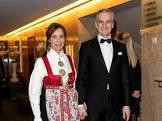

Displaying one random image from Erna Solberg: Erna Solberg_301.jpg


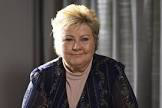

Displaying one random image from Bent Høie: Bent Høie_471.jpg


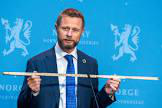

Displaying one random image from Lan Marie Berg: Lan Marie Berg_29.jpg


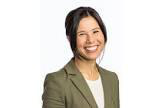

Displaying one random image from Sylvi Lysthaug: Sylvi Lysthaug_432.jpg


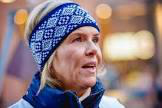

Displaying one random image from Espen Rostrup Nakstad: Espen Rostrup Nakstad_470.jpg


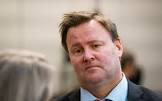

Displaying one random image from Trygve Slagsvold Vedum: Trygve Slagsvold Vedum_330.jpg


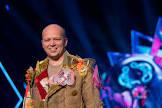

Displaying one random image from Camilla Stoltenberg: Camilla Stoltenberg_43.jpg


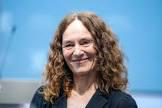

Displaying one random image from Fredrik Solvang: Fredrik Solvang_212.jpg


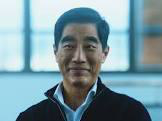

Displaying one random image from Donald Trump: Donald Trump_49.jpg


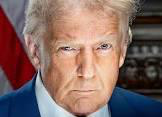

Displaying one random image from Joe Biden: Joe Biden_154.jpg


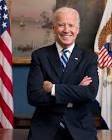

Displaying one random image from Anthony Fauci: Anthony Fauci_558.jpg


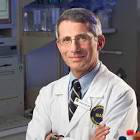

Displaying one random image from Bill Gates: Bill Gates_451.jpg


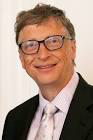

Displaying one random image from Random People Walking: Random People Walking_519.jpg


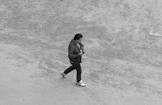

Displaying one random image from random people: random people_74.jpg


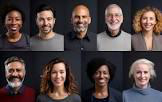

Displaying one random image from random facebook post: random facebook post_68.jpg


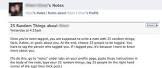

Displaying one random image from random twitter post: random twitter post_604.jpg


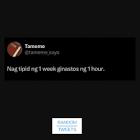

In [52]:
data_dir = 'data'

subfolders = [f.name for f in os.scandir(data_dir) if f.is_dir()]

# Iterate over each subfolder (each species)
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)

    # Get a list of all image files in the subfolder
    images = [f for f in os.listdir(subfolder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select a random image from the subfolder
    random_image = random.choice(images)

    # Full path to the selected image
    image_path = os.path.join(subfolder_path, random_image)

    # Open and display the image<
    image = Image.open(image_path)
    print(f"Displaying one random image from {subfolder}: {random_image}")
    display(image)

In [53]:
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [54]:
# Extract indices and corresponding labels
indices = np.arange(len(dataset))
labels = np.array([label for _, label in dataset.imgs])

# Split into training (70%) and combined validation/test (30%)
train_indices, val_test_indices, train_labels, val_test_labels = train_test_split(
    indices, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the combined validation/test set into validation (15%) and test (15%)
val_indices, test_indices, _, _ = train_test_split(
    val_test_indices, val_test_labels, test_size=0.5, stratify=val_test_labels, random_state=42)

# Create samplers for each set
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoader for each set
train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler, num_workers=2)

In [55]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the fully connected layer for 17 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 17)

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Using a scheduler to adjust the learning rate dynamically
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

c:\Users\sirifris\.conda\envs\poli_reco\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sirifris\.conda\envs\poli_reco\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
# Training loop
num_epochs = 10 # Doing 20 epochs
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.sampler)
    train_acc = correct / total

    scheduler.step()

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10, Train Loss: 1.3778, Train Acc: 0.5522, Val Acc: 0.6200
Epoch 2/10, Train Loss: 0.5745, Train Acc: 0.8106, Val Acc: 0.7830
Epoch 3/10, Train Loss: 0.3395, Train Acc: 0.8899, Val Acc: 0.8925
Epoch 4/10, Train Loss: 0.2496, Train Acc: 0.9206, Val Acc: 0.8668
Epoch 5/10, Train Loss: 0.1709, Train Acc: 0.9460, Val Acc: 0.9412
Epoch 6/10, Train Loss: 0.0600, Train Acc: 0.9819, Val Acc: 0.9953
Epoch 7/10, Train Loss: 0.0311, Train Acc: 0.9925, Val Acc: 0.9966
Epoch 8/10, Train Loss: 0.0257, Train Acc: 0.9941, Val Acc: 0.9966
Epoch 9/10, Train Loss: 0.0217, Train Acc: 0.9954, Val Acc: 0.9966
Epoch 10/10, Train Loss: 0.0163, Train Acc: 0.9964, Val Acc: 0.9980


In [57]:
# Loading the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on the test data
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / test_total
print(f'Test Accuracy: {test_acc:.4f}')

C:\Users\sirifris\AppData\Local\Temp\ipykernel_18668\1818604445.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 0.9973


In [58]:
from sklearn.metrics import confusion_matrix, classification_report

# Cassification report:
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

                        precision    recall  f1-score   support

         Anthony Fauci       1.00      1.00      1.00        87
             Bent Høie       1.00      1.00      1.00        87
            Bill Gates       1.00      1.00      1.00        87
   Camilla Stoltenberg       1.00      1.00      1.00        87
          Donald Trump       0.99      0.99      0.99        87
          Erna Solberg       1.00      1.00      1.00        87
 Espen Rostrup Nakstad       0.99      0.98      0.98        87
       Fredrik Solvang       1.00      1.00      1.00        87
             Joe Biden       1.00      1.00      1.00        87
      Jonas Gahr Støre       1.00      1.00      1.00        87
        Lan Marie Berg       0.99      1.00      0.99        87
 Random People Walking       1.00      1.00      1.00        87
        Sylvi Lysthaug       1.00      1.00      1.00        87
Trygve Slagsvold Vedum       1.00      1.00      1.00        87
  random facebook post       1.00      

<function matplotlib.pyplot.show(close=None, block=None)>

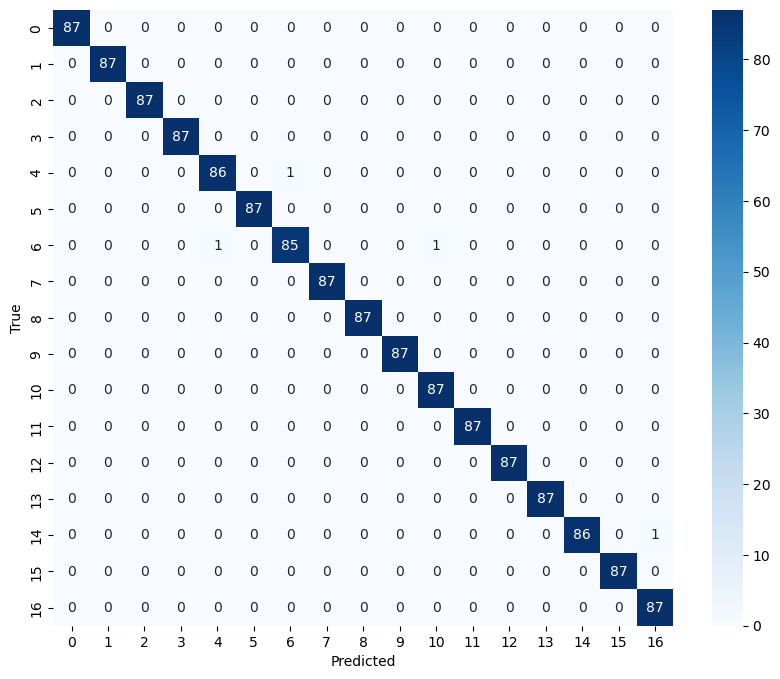

In [59]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show

# Classify the actual data

In [60]:
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 17)

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

c:\Users\sirifris\.conda\envs\poli_reco\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sirifris\.conda\envs\poli_reco\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\sirifris\AppData\Local\Temp\ipykernel_18668\97659088.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/p

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
image_folder = 'D:\\Images\\Covid\\output_images_detected'
output_folder = 'D:\\Images\\Covid\\classified_images'

In [62]:
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]

In [63]:
class_names = [
    'Jonas Gahr Støre',
    'Erna Solberg', 
    'Bent Høie',
    'Lan Marie Berg',
    'Sylvi Lysthaug',
    'Espen Rostrup Nakstad',
    'Trygve Slagsvold Vedum',
    'Camilla Stoltenberg',
    'Fredrik Solvang',
    'Donald Trump',
    'Joe Biden',
    'Anthony Fauci',
    'Bill Gates',
    'Random People Walking',
    'random people',
    'random facebook post',
    'random twitter post'
]

In [64]:
from pathlib import Path

for class_name in class_names:
    class_folder = Path(output_folder) / class_name
    class_folder.mkdir(parents=True, exist_ok=True)

In [65]:
import shutil

for image_path in image_paths:
    try:
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0)

        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)

        predicted_class = class_names[predicted.item()]

        target_folder = Path(output_folder) / predicted_class

        shutil.copy(image_path, target_folder)

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

print(f"All images have been classified")


KeyboardInterrupt: 